# Using library

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
#subset the data so that we can do the tSNE faster
data_X = digits.data[:600]
y = digits.target[:600]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(data_X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'digit':y})
tsne_df.head(10)

,X,Y,digit
0,37.739208,-18.806787,0
1,-18.368181,-0.344644,1
2,-8.307429,-4.497315,2
3,21.946308,4.991001,3
4,-29.894304,4.160649,4
5,16.611729,3.040757,5
6,-12.899954,-28.678867,6
7,-11.442452,21.588341,7
8,-3.532671,1.733132,8
9,10.807392,0.052017,9


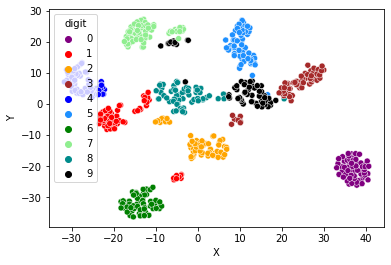

In [ ]:
sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red','orange','brown','blue',
                       'dodgerblue','green','lightgreen','darkcyan', 'black'],
              legend='full',
              data=tsne_df);

tSNE nicely captured the patterns in our data. Same digits are mostly in the same cluster.

# Implement

In [1]:
import numpy as np
import pylab

def Hbeta(D, beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X , no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [4]:
digits = load_digits()
data_X = digits.data[:]
y = digits.target[:]

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1797...
Computing P-values for point 500 of 1797...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Computing P-values for point 1000 of 1797...
Computing P-values for point 1500 of 1797...
Mean value of sigma: 10.619533
Iteration 10: error is nan
Iteration 20: error is nan
Iteration 30: error is nan
Iteration 40: error is nan
Iteration 50: error is nan
Iteration 60: error is nan
Iteration 70: error is nan
Iteration 80: error is nan
Iteration 90: error is nan
Iteration 100: error is nan
Iteration 110: error is nan
Iteration 120: error is nan
Iteration 130: error is nan
Iteration 140: error is nan
Iteration 150: error is nan
Iteration 160: error is nan
Iteration 170: error is nan
Iteration 180: error is nan
Iteration 190: error is nan
Iteration 200: error is nan
Iteration 210: error is nan
Iteration 220: error is nan
Iteration 230: error is nan
Iteration 240: error is nan
Iteration 250: error is nan
Iteration 260: error is nan
Iteration 270: error is nan
Iteration 280: error is nan
Iteration 290: error is nan
Iteration 300: error is nan
Iteration 310: error is nan
Iteration 320: error

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


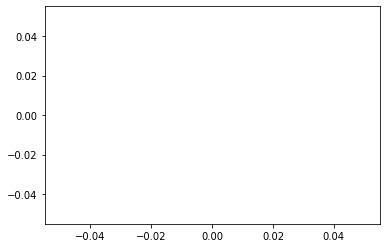

In [7]:
    Y = tsne(data_X, 2, 50, 20.0)
    pylab.scatter(Y[:, 0], Y[:, 1], 20, y)
    pylab.show()